# Import Package

In [1]:
#!conda install keras
#!pip install keras

In [2]:
#!conda install tensorflow
#!pip install tensorflow

In [4]:
#!conda install pandas_ta
#!pip install pandas_ta

In [5]:
!conda list

# packages in environment at D:\anaconda3\envs\env4LDA:
#
# Name                    Version                   Build  Channel
absl-py                   0.13.0                   pypi_0    pypi
argon2-cffi               20.1.0           py39h2bbff1b_1  
astunparse                1.6.3                    pypi_0    pypi
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
bottleneck                1.3.2            py39h7cc1a96_1  
brotli                    1.0.9                ha925a31_2  
brotlipy                  0.7.0           py39h2bbff1b_1003  
ca-certificates           2021.7.5             haa95532_1  
cachetools                4.2.2                    pypi_0    pypi
certifi                   2021.5.30        py39haa95532_0  
cffi           

tensorflow                2.6.0                    pypi_0    pypi
tensorflow-estimator      2.6.0                    pypi_0    pypi
termcolor                 1.1.0                    pypi_0    pypi
terminado                 0.9.4            py39haa95532_0  
testpath                  0.5.0              pyhd3eb1b0_0  
threadpoolctl             2.2.0              pyhbf3da8f_0  
tk                        8.6.10               he774522_0  
tornado                   6.1              py39h2bbff1b_0  
traitlets                 5.0.5              pyhd3eb1b0_0  
typing-extensions         3.7.4.3                  pypi_0    pypi
tzdata                    2021a                h5d7bf9c_0  
urllib3                   1.26.6             pyhd3eb1b0_1  
vc                        14.2                 h21ff451_1  
vs2015_runtime            14.27.29016          h5e58377_2  
wcwidth                   0.2.5                      py_0  
webencodings              0.5.1            py39haa95532_1  
werkzeug        

In [1]:
#Import yfinance to get stock market data 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import pandas_ta
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from matplotlib.pyplot import figure

# Pre-processing (khám phá + check dữ liệu)


Mục đích của mục này là để tìm hiểu mức độ tương đồng giữa EMA (một độ đo thường được dùng cho bài toán liên quan đến chuỗi thời gian, như dự đoán giá chứng khoáng) và Average (giá trị trung bình). 

Lấy dữ liệu chứng khoáng từ tập đoàn Microsoft, khoảng thời gian từ "1986-03-13" đến "2020-12-30".

In [7]:
df = pd.read_csv("data/data.csv")
df.reset_index(inplace=True)

Thể hiện bảng dữ liệu.

In [8]:
df

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061491,1031788800
1,1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063687,308160000
2,2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064785,133171200
3,3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063138,67766400
4,4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062040,47894400
...,...,...,...,...,...,...,...,...
8767,8767,2020-12-22,222.690002,225.630005,221.850006,223.940002,222.484772,22612200
8768,8768,2020-12-23,223.110001,223.559998,220.800003,221.020004,219.583740,18699600
8769,8769,2020-12-24,221.419998,223.610001,221.199997,222.750000,221.302490,10550600
8770,8770,2020-12-28,224.449997,226.029999,223.020004,224.960007,223.498138,17933500


In [9]:
df.describe()

,index,Open,High,Low,Close,Adj Close,Volume
count,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8.772000e+03
mean,4385.500000,32.866332,33.225090,32.501516,32.873844,27.756048,5.982674e+07
std,2532.402614,39.447411,39.858851,39.012248,39.459279,39.179716,3.864257e+07
min,0.000000,0.088542,0.092014,0.088542,0.090278,0.057099,2.304000e+06
25%,2192.750000,3.765625,3.812500,3.734375,3.771485,2.385376,3.598048e+07
50%,4385.500000,26.500000,26.799999,26.209999,26.469999,18.475947,5.292935e+07
75%,6578.250000,35.662499,36.062500,35.281250,35.632812,26.358562,7.363295e+07
max,8771.000000,229.270004,232.860001,227.350006,231.649994,229.543701,1.031789e+09


Vẽ đồ thị đường để biểu diễn biến động chứng khoáng trong khoảng thời gian trên.

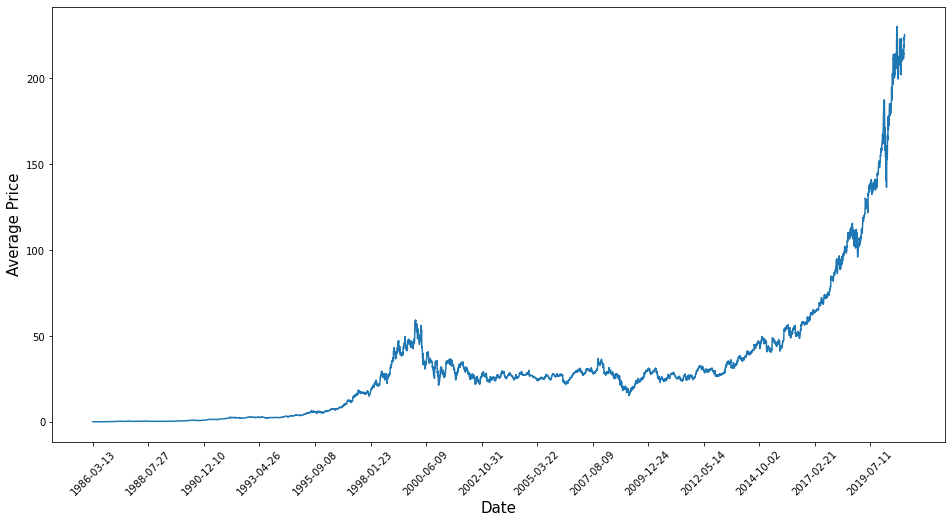

In [10]:
avg_price_list = (df['Low']+df['High'])/2.0
plt.figure(figsize = (16,8))
plt.plot(range(df.shape[0]), avg_price_list)
plt.xticks(range(0,df.shape[0],600),df['Date'].loc[::600],rotation=45)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Average Price',fontsize=15)
plt.show()

Thêm cột "avg_price" bằng cách lấy trung bình cộng hai cột "High" và "Low". 

In [11]:
df['avg_price'] = df.apply(lambda row: (row.Low + row.High)/2,axis=1)

In [12]:
new_df = df.copy()
new_df

,index,Date,Open,High,Low,Close,Adj Close,Volume,avg_price
0,0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061491,1031788800,0.095052
1,1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063687,308160000,0.099826
2,2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064785,133171200,0.101997
3,3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063138,67766400,0.101128
4,4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062040,47894400,0.098958
...,...,...,...,...,...,...,...,...,...
8767,8767,2020-12-22,222.690002,225.630005,221.850006,223.940002,222.484772,22612200,223.740005
8768,8768,2020-12-23,223.110001,223.559998,220.800003,221.020004,219.583740,18699600,222.180000
8769,8769,2020-12-24,221.419998,223.610001,221.199997,222.750000,221.302490,10550600,222.404999
8770,8770,2020-12-28,224.449997,226.029999,223.020004,224.960007,223.498138,17933500,224.525002


Dùng thư viện "pandas_ta" để thêm cột "EMA_10"  - exponential moving average (10 days length).

In [13]:
import pandas_ta
df = new_df[['avg_price']]
df.ta.ema(close='avg_price', length=10, append=True)
df

D:\anaconda3\envs\env4LDA\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result


,avg_price,EMA_10
0,0.095052,NaN
1,0.099826,NaN
2,0.101997,NaN
3,0.101128,NaN
4,0.098958,NaN
...,...,...
8767,223.740005,217.865544
8768,222.180000,218.649991
8769,222.404999,219.332719
8770,224.525002,220.276771


Như quan sát phía trên, cột "EMA-10" sẽ có vài giá trị NaN, chính xác là 9, vì day lengths (lượng ngày cần để tạo ra một ema mới là 9), như vậy thì cột "EMA-10" sẽ có giá trị từ hàng thứ 10. Và ta sẽ cần loại bỏ 9 hàng NaN.

In [14]:
df.dropna(subset=['EMA_10'],inplace=True)

D:\anaconda3\envs\env4LDA\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
df

,avg_price,EMA_10
9,0.093316,0.096267
10,0.095486,0.096125
11,0.095052,0.095930
12,0.095052,0.095771
13,0.095920,0.095798
...,...,...
8767,223.740005,217.865544
8768,222.180000,218.649991
8769,222.404999,219.332719
8770,224.525002,220.276771


Sau loại dropna, ta thấy số lượng hàng từ 8872 -> 8763, đúng 9 hàng. Như vậy dữ liệu trên đã được tiền xử lý hoàn tất, sẵn sàng cho để huấn luyện mô hình hồi quy tuyến tính.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[['avg_price']], df[['EMA_10']], test_size=.2)

In [17]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)

LinearRegression()

Sau khi huấn luyện mô hình, ta sẽ biểu diễn khả năng dự đoán của mô hình huấn luyện bằng đồ thị đường và điểm.

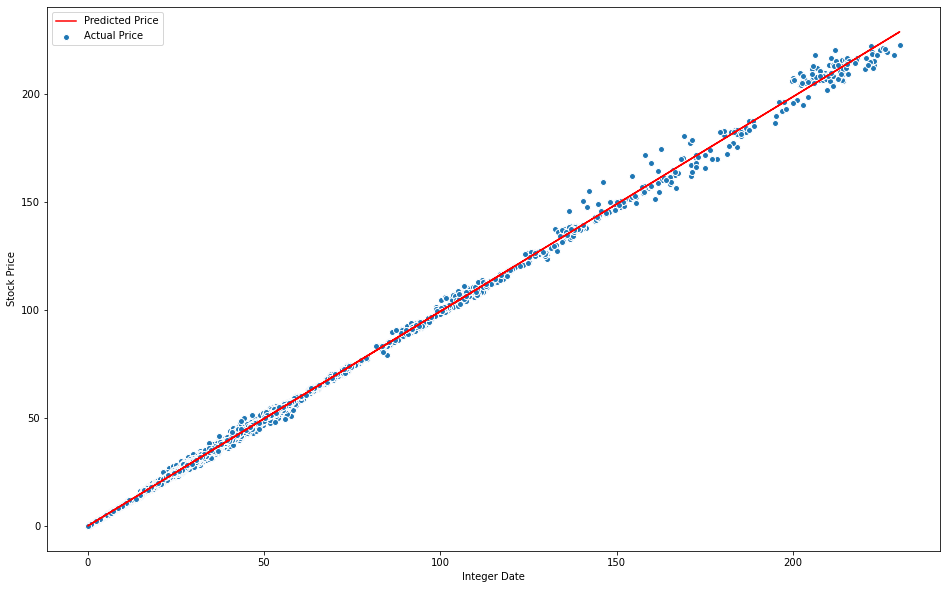

In [18]:
plt.figure(1, figsize=(16,10))
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.plot(X_train, model.predict(X_train), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:

# Generate array with predicted values
y_pred = model.predict(X_test)

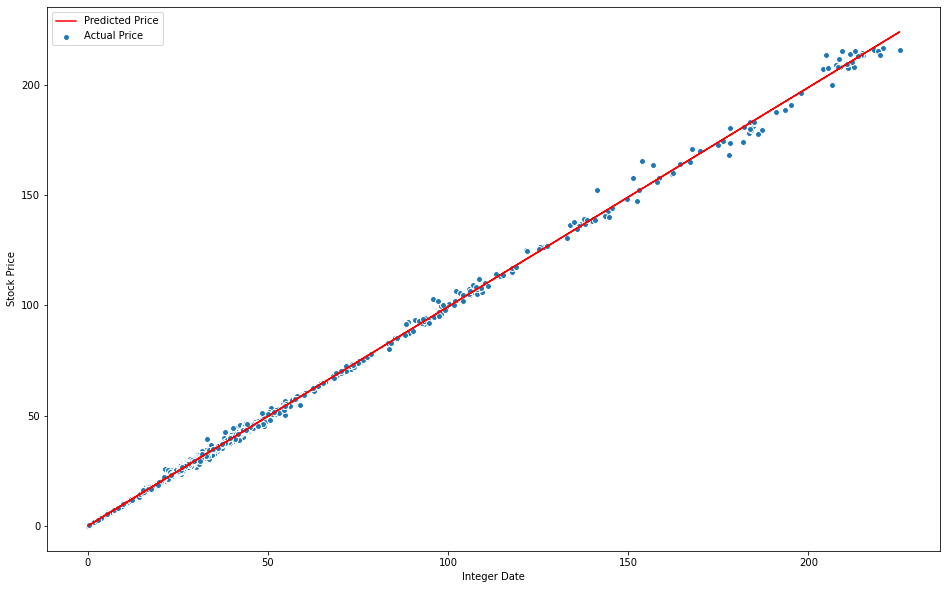

In [20]:
plt.figure(1, figsize=(16,10))
plt.scatter(X_test, y_test, edgecolor='w', label='Actual Price')
plt.plot(X_test, model.predict(X_test), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Model Coefficients: [[0.99325629]]
Mean Absolute Error: 0.5709921462611287


Kết luận: Như vậy sau quá trình khám phá dữ liệu trên ta nhận thấy điều sau: Giá trị trung bình có thể dùng trong bài toán dự đoán giá chứng khoán nhưng cần một phương pháp tiếp cận khác vì: <br/>
1. Trong một chuỗi dữ liệu giá trị trung bình của một công ty/tập đoàn trong khoảng thời gian dài, những giá trị đầu tiên và giá trị cuối cùng sẽ chênh lệch rất nhiều, do đó chúng cần được được gom thành nhóm.
2. Việc chuẩn hóa các giá trị trong một nhóm sẽ cần được thực hiện để có thể xem xét chính xác ảnh hưởng của những giá trị biên (Min, Max).
<br/>=> Đề xuất sử dụng LSTM kết hợp với tiền xử lý smoothing window và MinMaxScaler làm mô hình dự đoán

# Modeling - P.1(cài đặt LSTM)

In [22]:
data = pd.read_csv("data/data.csv")
data.reset_index(inplace=True)
high_prices = data['High'].values
low_prices = data['Low'].values
#we take avg price from stock trading
avg_prices = (high_prices+low_prices)/2
train_size = int(3/4* len(avg_prices)) #splitting percentage HERE
test_size = len(avg_prices) - train_size
train_data = avg_prices[:train_size]
test_data = avg_prices[:test_size]
#Reshape the data for reprocessing
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
#all_mid_data = np.concatenate([train_data,test_data],axis=0)

Chúng ta có thể thấy giá stock ở những năm 1980 thấp hơn rất nhiều so với những năm 2020. Chính vì thế chúng ta cần phải scale data với min max scaler. Để giá stock ở những năm 1980 vẫn giữ được ý nghĩa (không phải bằng 0 vì khoảng cách giữa hai giá stock min và max quá lớn) chúng ta có smoothing_window_size quy định các khoảng mà chúng ta sẽ áp dụng min max scaler

In [23]:
#Scale data with min max scaler
scaler = MinMaxScaler()
smoothing_window_size = 1000
for di in range(0,train_size,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

Vì đầu vào của mô hình yêu cầu dữ liệu phải là một mảng 3 chiều nên ta cần phải reshape lại với kích thước ban đầu cộng với 1 cho mô hình LSTM

In [24]:
#Make a 3D array data for LSTM
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

Mục tiêu của chúng ta là sử dụng time_step ngày để có thể dự đoán ngày thứ time_step chính vì thế tập X của chúng ta là các mảng gồm time_step ngày và tập Y chính là giá trị của ngày thứ time_step+1 và dùng để huấn luyện

Ở đây chúng ta sử dụng time_step = 100 tức sử dụng giá stock 100 ngày để dự đoán ngày thứ 101

In [25]:
#Create a data set for training and testing
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step=100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [26]:

model = Sequential()

#Adding a first LSTM layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)
model.summary()

Epoch 1/10
203/203 [==============================] - 28s 119ms/step - loss: 0.0150
Epoch 2/10
203/203 [==============================] - 26s 129ms/step - loss: 0.0078
Epoch 3/10
203/203 [==============================] - 30s 148ms/step - loss: 0.0063
Epoch 4/10
203/203 [==============================] - 20s 99ms/step - loss: 0.0056
Epoch 5/10
203/203 [==============================] - 22s 107ms/step - loss: 0.0048
Epoch 6/10
203/203 [==============================] - 25s 125ms/step - loss: 0.0041
Epoch 7/10
203/203 [==============================] - 21s 106ms/step - loss: 0.0037
Epoch 8/10
203/203 [==============================] - 23s 114ms/step - loss: 0.0033
Epoch 9/10
203/203 [==============================] - 34s 165ms/step - loss: 0.0032
Epoch 10/10
203/203 [==============================] - 27s 133ms/step - loss: 0.00280s - loss: 0.00
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Para

In [27]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
Y_test =  scaler.inverse_transform(Y_test)

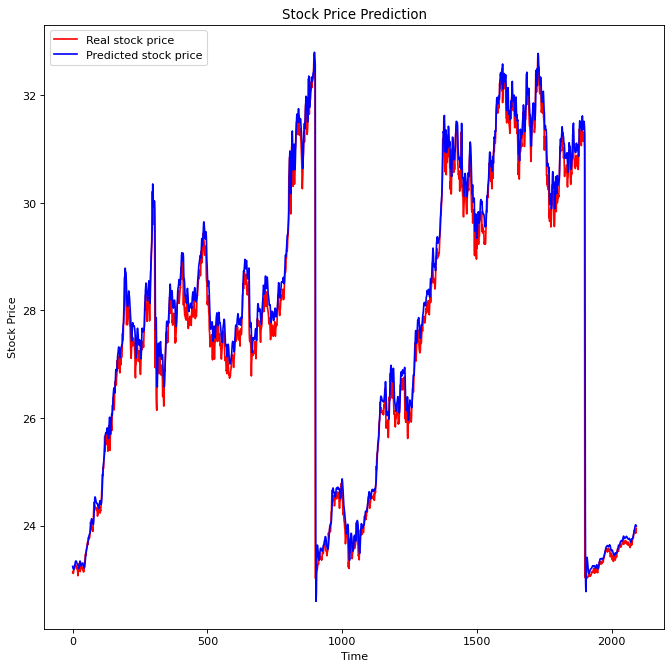

In [28]:
# Visualising the results
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
figure(figsize=(10, 10), dpi=80)
plt.plot(range(Y_test.shape[0]),Y_test, color = 'red', label = 'Real stock price')
plt.plot(range(predicted_stock_price.shape[0]),predicted_stock_price, color = 'blue', label = 'Predicted stock price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Mean Absolute Error:", mean_absolute_error(Y_test, predicted_stock_price))

Mean Absolute Error: 0.22920332596179
Coefficient of Determination: 0.9783369826722107


=> Mô hình đạt được kết quả khả quan so với Linear Regression, chứng minh được bằng cách học thông qua mô hình LSTMs và các phương pháp preprocessing phù hợp với kiểu dữ liệu time series, bài toán dự đoán chứng khoán có thể được tối ưu hóa.

# Modeling - P.2 (thử với nhiều parameter)

In [32]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)
class LSTM_Model():
    def __init__(self, time_step, smoothing_window_size):
        self.time_step = time_step
        self.smoothing_window_size =  smoothing_window_size
    def get_and_split_data(self):
        self.data = pd.read_csv("data/data.csv")
        self.data.reset_index(inplace=True)
        high_prices = self.data['High'].values
        low_prices = self.data['Low'].values
        self.avg_prices = (high_prices+low_prices)/2
        self.train_size = int(3/4* len(self.avg_prices)) #splitting percentage HERE
        self.test_size = len(self.avg_prices) - self.train_size
        self.train_data = self.avg_prices[:self.train_size]
        self.test_data = self.avg_prices[:self.test_size]
        self.train_data = self.train_data.reshape(-1,1)
        self.test_data = self.test_data.reshape(-1,1)
    def smoothing_function(self):
        self.scaler = MinMaxScaler()
        for di in range(0,self.train_size,self.smoothing_window_size):
            self.scaler.fit(self.train_data[di:di+self.smoothing_window_size,:])
            self.train_data[di:di+self.smoothing_window_size,:] = self.scaler.transform(self.train_data[di:di+self.smoothing_window_size,:])
        self.train_data = self.train_data.reshape(self.train_data.shape[0],self.train_data.shape[1], 1)
        self.test_data = self.test_data.reshape(self.test_data.shape[0], self.test_data.shape[1], 1)
    def create_and_fit_model(self):
        self.X_train, self.Y_train = create_dataset(self.train_data, self.time_step)
        self.X_test, self.Y_test = create_dataset(self.test_data, self.time_step)
        self.model = Sequential()
        #Adding a first LSTM layer
        self.model.add(LSTM(units = 50, return_sequences = True, input_shape = (self.X_train.shape[1], 1)))
        self.model.add(Dropout(0.2))
        # Adding a second LSTM layer
        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))
        # Adding a third LSTM layer
        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))
        # Adding a fourth LSTM layer 
        self.model.add(LSTM(units = 50))
        self.model.add(Dropout(0.2))
        # Adding the output layer
        self.model.add(Dense(units = 1))
        # Compiling the RNN
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        # Fitting the RNN to the Training set
        self.history = self.model.fit(self.X_train, self.Y_train, epochs = 1, batch_size = 32)
    def predict(self):
        self.predicted_stock_price = self.model.predict(self.X_test)
        self.predicted_stock_price = self.scaler.inverse_transform(self.predicted_stock_price)
        self.Y_test =  self.scaler.inverse_transform(self.Y_test)
        return mean_absolute_error(self.Y_test, self.predicted_stock_price)
    def plot_fig(self):
        figure(figsize=(10, 10), dpi=80)
        plt.plot(range(self.Y_test.shape[0]),self.Y_test, color = 'red', label = 'Real stock price')
        plt.plot(range(self.predicted_stock_price.shape[0]),self.predicted_stock_price, color = 'blue', label = 'Predicted stock price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
    def plot_loss_fig(self):
        figure(figsize=(10, 10), dpi=80)
        plt.plot(self.history.hitory['Loss'],label='Training Loss')
        plt.plot(self.history.history['val_loss'],label='Validation Loss')
        plt.legend()

In [33]:
window_size_list=[1000,2500,5000]
time_step_list=[100,150,200]
test_errs = []
for window_size in window_size_list:
    for time_step in time_step_list:
        print("Window size:", window_size)
        print("Time step:",time_step)
        my_model = LSTM_Model(time_step,window_size)
        my_model.get_and_split_data()
        my_model.smoothing_function()
        my_model.create_and_fit_model()
        test_errs.append(my_model.predict())
        print("-----------------------")

Window size: 1000
Time step: 100
203/203 [==============================] - 24s 97ms/step - loss: 0.0169
-----------------------
Window size: 1000
Time step: 150
201/201 [==============================] - 34s 150ms/step - loss: 0.0141
-----------------------
Window size: 1000
Time step: 200
200/200 [==============================] - 49s 225ms/step - loss: 0.0163
-----------------------
Window size: 2500
Time step: 100
203/203 [==============================] - 26s 106ms/step - loss: 0.0089
-----------------------
Window size: 2500
Time step: 150
201/201 [==============================] - 47s 217ms/step - loss: 0.0092
-----------------------
Window size: 2500
Time step: 200
200/200 [==============================] - 58s 268ms/step - loss: 0.0101
-----------------------
Window size: 5000
Time step: 100
203/203 [==============================] - 28s 118ms/step - loss: 0.0063
-----------------------
Window size: 5000
Time step: 150
201/201 [==============================] - 46s 200ms/step 

,100,150,200
1000,0.474965,0.440243,0.470327
2500,0.450330,0.309207,0.339489
5000,0.083520,0.171164,0.083616


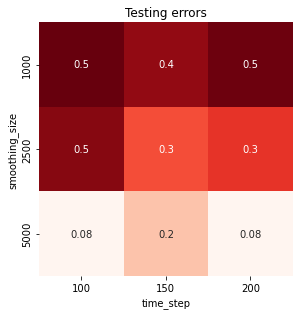

In [34]:
# Trực quan hóa kết quả

test_errs_df = pd.DataFrame(
    data=np.array(test_errs).reshape(len(window_size_list), -1), 
    index=window_size_list, columns=time_step_list)
display(test_errs_df)
min_err = min(test_errs)
max_err = max(test_errs)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
sns.heatmap(test_errs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.001', cmap='Reds')
plt.title('Testing errors'); plt.xlabel('time_step'); plt.ylabel('smoothing_size');

=> Biểu đồ cho thấy mức độ quan trọng của việc lựa chọn của smoothing size phù hợp. Vì smoothing window size lớn sẽ cho cái nhìn tổng quan hơn đến sự thay đổi giá trị theo thời gian của dữ liệu, từ đó giúp cho mô hình đạt được kết quả cao. 